In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import time
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Part A - Linear Classification Models

## A1. Data Preparation

### 1. Loading the Dataset

### 2. Normalize pixel values to [0,1] range

### 3. Keep original shape for neural networks

In [34]:
# Normalize pixel values to [0,1] range

transform = transforms.Compose([transforms.ToTensor()]) # Converts images to PyTorch tensor (Multi-Dimensional Array)
# transforms -> Image transformations (including Normalize, which we will use)
# .Compose -> Combines multiple transformations
# .ToTensor -> Converts images to PyTorch tensor + Scales pixel values from [0,255] to [0,1]

# Loading the training set
mnist_train = torchvision.datasets.MNIST(
    root='data', # root -> directory to download/store/load data
    train=True,  # train -> true to download training data
    download=True, # download -> True needed only once
    transform = transform # Already defined above
)

# Loading the test set
mnist_test  = torchvision.datasets.MNIST(
    root='data',
    train=False,  # train -> false to download test data
    download=True, # download -> True needed only once
    transform = transform
)

# Storing training data
x_train_init = mnist_train.data #allows direct access to the images data
y_train_init = mnist_train.targets #allows direct access to the images labels

# Storing test data
x_test_original = mnist_test.data
y_test_original = mnist_test.targets

print(f"X_train: {x_train_init.shape}, Y_train: {y_train_init.shape}")
print(f"X_test: {x_test_original.shape}, Y_test: {y_test_original.shape}")

X_train: torch.Size([60000, 28, 28]), Y_train: torch.Size([60000])
X_test: torch.Size([10000, 28, 28]), Y_test: torch.Size([10000])


### 4. Flatten images for linear models (28x28 -> 784 features)
### 5. Split data stratified into train and validation using sklearn

In [35]:
y_np = y_train_init.numpy()  # Convert to numpy array for sklearn compatibility

# Split the dataset
train_idx, val_idx = train_test_split(
    np.arange(len(y_np)), # Array of indices
    test_size = 1/6, # Remaining
    stratify = y_np, # Ensures class distribution is same in both sets
    random_state = 42 # Ensures that same split is used every time
    )

x_train_original = x_train_init[train_idx]/ 255.0
x_val_original = x_train_init[val_idx] / 255.0
x_test_original = x_test_original / 255.0

x_test_idx = np.arange(len(x_test_original))

y_train_original = y_train_init[train_idx]
y_val_original = y_train_init[val_idx]

# Flatten the images
x_train_flat = x_train_original.flatten(start_dim=1)  # Flatten to [N, 784]
x_val_flat = x_val_original.flatten(start_dim=1)  # Flatten to [N, 784]
x_test_flat = x_test_original.flatten(start_dim=1)    # Flatten to [N, 784]

x_train_flat_idx = np.arange(len(x_train_flat))
x_val_flat_idx = np.arange(len(x_val_flat))
x_test_flat_idx = np.arange(len(x_test_flat))

print(f"X_train: {x_train_flat.shape}, Y_train: {y_train_original.shape}")
print(f"X_val: {x_val_flat.shape}, Y_val: {y_val_original.shape}")
print(f"X_test: {x_test_flat.shape}, Y_test: {y_test_original.shape}")

len(train_idx), len(val_idx), len(x_test_original)

X_train: torch.Size([50000, 784]), Y_train: torch.Size([50000])
X_val: torch.Size([10000, 784]), Y_val: torch.Size([10000])
X_test: torch.Size([10000, 784]), Y_test: torch.Size([10000])


(50000, 10000, 10000)

In [36]:
print("Size of x_train_original:", x_train_original.shape)
print("Size of x_val_original:", x_val_original.shape)
print("Size of x_test_original:", x_test_original.shape)
print("\n")
print("Size of x_train_flat:", x_train_flat.shape)
print("Size of x_val_flat:", x_val_flat.shape)
print("Size of x_test_flat:", x_test_flat.shape)
print("\n")
print("Size of y_train_original:", y_train_original.shape)
print("Size of y_val_original:", y_val_original.shape)
print("Size of y_test_original:", y_test_original.shape)
print("\n")
print("Size of y_train_flat:", y_train_original.shape)
print("Size of y_val_flat:", y_val_original.shape)
print("Size of y_test_flat:", y_test_original.shape)
print("\n")
print("Size of train_idx:", len(train_idx))
print("Size of val_idx:", len(val_idx))
print("Size of test_idx:", len(x_test_original))


Size of x_train_original: torch.Size([50000, 28, 28])
Size of x_val_original: torch.Size([10000, 28, 28])
Size of x_test_original: torch.Size([10000, 28, 28])


Size of x_train_flat: torch.Size([50000, 784])
Size of x_val_flat: torch.Size([10000, 784])
Size of x_test_flat: torch.Size([10000, 784])


Size of y_train_original: torch.Size([50000])
Size of y_val_original: torch.Size([10000])
Size of y_test_original: torch.Size([10000])


Size of y_train_flat: torch.Size([50000])
Size of y_val_flat: torch.Size([10000])
Size of y_test_flat: torch.Size([10000])


Size of train_idx: 50000
Size of val_idx: 10000
Size of test_idx: 10000


In [37]:
batch_size = 64

# Original datasets (unflattened)
train_dataset = TensorDataset(x_train_original, y_train_original)
val_dataset = TensorDataset(x_val_original, y_val_original)
test_dataset = TensorDataset(x_test_original, y_test_original)

# Flattened datasets
train_dataset_flat = TensorDataset(x_train_flat, y_train_original)
val_dataset_flat = TensorDataset(x_val_flat, y_val_original)
test_dataset_flat = TensorDataset(x_test_flat, y_test_original)

print('Sizes - train, val, test:', len(train_dataset), len(val_dataset), len(test_dataset))
print('Flat Sizes - train, val, test :', len(train_dataset_flat), len(val_dataset_flat), len(test_dataset_flat))


Sizes - train, val, test: 50000 10000 10000
Flat Sizes - train, val, test : 50000 10000 10000


### 6. Create appropriate PyTorch DataLoaders

In [38]:
# Original loaders (loads a batch of the dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# batch_size = 64: common default choice
# shuffle: True for Training (so it doesn't learn order of samples), False otherwise

# Flattened loaders
train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat = DataLoader(val_dataset_flat, batch_size=batch_size, shuffle=False)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=batch_size, shuffle=False)


## A2 — Logistic Regression Implementation (Binary Classification Task)

### 1. Implement Binary Cross-Entropy Loss
### 2. Use Sigmoid Activation Function

In [39]:
# Mathematical Equation for BCE Loss
def BCE_Loss_eqn(y_true, y_pred):
    return -(y_true * torch.log(y_pred) + (1-y_true) * torch.log(1-y_pred)).mean()

# Calculating BCE Loss
def BCE_Loss(w, b, X, y):
    z = torch.matmul(X, w) + b
    pred = torch.sigmoid(z)
    bce_loss = BCE_Loss_eqn(y, pred)
    with torch.no_grad():
        pred_labels = (pred > 0.5).float()
        accuracy = (pred_labels == y).float().mean()

    return bce_loss, accuracy


In [40]:
y_np_train = y_train_original.numpy()
y_np_val = y_val_original.numpy()

# Filters for 0 and 1
mask = (y_np_train == 0) | (y_np_train == 1)

#New dataset: subset of the original containing only zeros and ones
X01 = x_train_flat[mask] # Filter Features that are ONLY 0 or 1
y01 = y_np_train[mask] # Filter Labels that are ONLY 0 or 1

print('Samples for 0s and 1s:', X01.shape[0])

# New Datasets that contain only 0s and 1s with same ratio
train_x01, temp_x01 = train_test_split(
    np.arange(len(y01)),
    test_size = 0.4,
    stratify = y01,
    random_state = 42
)

val_x01, test_x01  = train_test_split(
    temp_x01,
    test_size = 0.5,
    stratify = y01[temp_x01],
    random_state = 42
)

# Split into train, val, test subsets
X01_train, y01_train = X01[train_x01], y01[train_x01]
X01_val,   y01_val   = X01[val_x01],   y01[val_x01]
X01_test,  y01_test  = X01[test_x01],  y01[test_x01]

print("Train: ", len(X01_train), len(y01_train))
print("Val: ",   len(X01_val), len(y01_val))
print("Test: ",  len(X01_test), len(y01_test))

Samples for 0s and 1s: 10554
Train:  6332 6332
Val:  2111 2111
Test:  2111 2111


### 3. Implement Logistic Regression from Scratch using PyTorch Tensors
### 4. Use Gradient Descent Optimization (Lr = 0.01)
### 5. Train for sufficient epochs until convergence

In [41]:
D = X01_train.shape[1] # No. of Features
N = X01_train.shape[0] # No. of Samples

x_t = torch.tensor(X01_train, dtype=torch.float32) # Convert Features to Tensor
y_t = torch.tensor(y01_train, dtype=torch.float32) # Convert Labels to Tensor

x_v = torch.tensor(X01_val, dtype=torch.float32) # Convert Features to Tensor
y_v = torch.tensor(y01_val, dtype=torch.float32) # Convert Labels to Tensor

w = torch.zeros(D, dtype=torch.float32, requires_grad=True) # weights = zeros of size D
b = torch.zeros(1, dtype=torch.float32, requires_grad=True) # bias = 0

lr = 0.01
max_epochs = 100000

best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0
min_delta = 1e-3

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def early_stopping_check(val_loss, best_val_loss, patience, min_delta, epochs_without_improvement):
    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            return best_val_loss, epochs_without_improvement
    return best_val_loss, epochs_without_improvement

for epoch in range(max_epochs):

    # Forward pass
    train_loss, train_acc = BCE_Loss(w, b, x_t, y_t)

    # Backward pass
    train_loss.backward()

    # Update parameters
    with torch.no_grad():  # Disable gradient tracking for updates
        w -= lr * w.grad
        b -= lr * b.grad

        # Zero gradients
        w.grad.zero_()
        b.grad.zero_()

    # Store training metrics
    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc.item())

    # Validation (no gradient needed)
    with torch.no_grad():
        val_loss, val_acc = BCE_Loss(w, b, x_v, y_v)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc.item())

    best_val_loss, epochs_without_improvement = early_stopping_check(
        val_loss.item(), best_val_loss, patience, min_delta, epochs_without_improvement
    )

    final_epoch = epoch

    if epochs_without_improvement >= patience:
        print("Early stopping at epoch", final_epoch)
        break

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final epoch: {final_epoch}")



/tmp/ipython-input-1408271127.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t = torch.tensor(X01_train, dtype=torch.float32) # Convert Features to Tensor
/tmp/ipython-input-1408271127.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_v = torch.tensor(X01_val, dtype=torch.float32) # Convert Features to Tensor


Early stopping at epoch 356
Best validation loss: 0.0453
Final epoch: 356


### 6. Training and Validation Loss Curves
### 7. Training and Validation Accuracy Curves

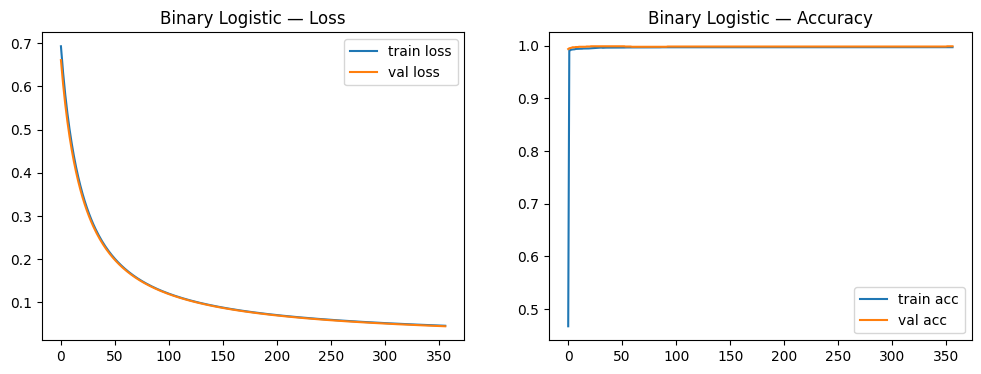

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')

plt.title('Binary Logistic — Loss'); plt.legend()

plt.subplot(1,2,2)

plt.plot(train_accuracies, label='train acc')
plt.plot(val_accuracies, label='val acc')

plt.title('Binary Logistic — Accuracy'); plt.legend()
plt.show()

### 8. Final Test Accuracy and Confusion Matrix

In [43]:
# First, convert test data to tensors
x_test = torch.tensor(X01_test, dtype=torch.float32)
y_test = torch.tensor(y01_test, dtype=torch.float32)

# Evaluate on test set (no gradients needed)
with torch.no_grad():
    test_loss, test_acc = BCE_Loss(w, b, x_test, y_test)
    # Get predictions
    z = torch.matmul(x_test, w) + b
    test_preds = torch.sigmoid(z).numpy()  # Convert to numpy array

print(f'Test accuracy: {test_acc.item():.4f}')

# Convert predictions to class labels (0 or 1)
pred_labels = (test_preds >= 0.5).astype(int)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y01_test, pred_labels)
print('Confusion matrix:')
print(cm)

# You can also print classification report for more metrics
from sklearn.metrics import classification_report
print('\nClassification report:')
print(classification_report(y01_test, pred_labels))

Test accuracy: 0.9967
Confusion matrix:
[[ 983    5]
 [   2 1121]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       988
           1       1.00      1.00      1.00      1123

    accuracy                           1.00      2111
   macro avg       1.00      1.00      1.00      2111
weighted avg       1.00      1.00      1.00      2111



/tmp/ipython-input-1303853903.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(X01_test, dtype=torch.float32)


## A3 - Softmax Regression Implementation

### 1. Implement Softmax Regression from scratch
### 2. Use Softmax activation and cross-entropy loss
### 3. Use same optimization settings as Logistic Regression

In [44]:
def softmax_eqn(z):
    z = z - z.max(dim=1, keepdim=True)[0]   # numerical stability
    expz = torch.exp(z)
    return expz / (expz.sum(dim=1, keepdim=True) + 1e-8)

def cross_entropy_loss(logits, y_true):
    probs = softmax_eqn(logits)
    N = logits.shape[0]
    idx = torch.arange(N)
    loss = -torch.log(probs[idx, y_true] + 1e-8).mean()
    return loss, probs

# Match your variable naming from BCE implementation
X_train = x_train_flat[x_train_flat_idx]
y_train = y_np_train[x_train_flat_idx]

X_val = x_val_flat[x_val_flat_idx]
y_val = y_np_val[x_val_flat_idx]

# Convert to tensors (match your dtype conventions)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

x_soft = x_train_flat[x_train_flat_idx]
y_soft = y_np_train[x_train_flat_idx]

K = 10  # Number of Classes
D = X_train.shape[1]  # Match your D = X01_train.shape[1] convention

# Weight initialization (keeping your improved initialization)
W = torch.randn(D, K) * 0.01  # Match your 'w' naming but keeping matrix form
b = torch.zeros(K)  # Match your 'b' naming

# Training parameters (match your BCE implementation)
lr = 0.01
max_epochs = 100000  # Match your max_epochs naming
patience = 10
min_delta = 1e-3

# Tracking (match your lists from BCE)
train_losses_manual = []
train_accuracies_manual = []
val_losses_manual = []
val_accuracies_manual = []

# Convert training data to tensors (match your implementation)
X_t = torch.tensor(x_soft, dtype=torch.float32)
y_t = torch.tensor(y_soft, dtype=torch.long)

def softmax_manual(X_t, y_t, W, b, lr, max_epochs):
    # Main training loop (structured like your BCE implementation)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(max_epochs):
        # Forward pass
        logits = torch.matmul(X_t, W) + b  # Match your matmul convention
        loss, probs = cross_entropy_loss(logits, y_t)

        # Backward pass
        N = X_t.shape[0]
        grad_logits = probs.clone()
        grad_logits[torch.arange(N), y_t] -= 1.0
        grad_logits /= N

        grad_W = X_t.t().matmul(grad_logits).float()
        grad_b = grad_logits.sum(dim=0).float()

        # Update parameters (match your update style)
        with torch.no_grad():
            W -= lr * grad_W
            b -= lr * grad_b

        # Training metrics
        train_losses_manual.append(loss.item())
        pred_labels = probs.argmax(dim=1).numpy()
        train_accuracies_manual.append((pred_labels == y_train).mean())

        # Validation metrics
        with torch.no_grad():
            val_logits = torch.matmul(X_val_t, W) + b
            val_loss, val_probs = cross_entropy_loss(val_logits, y_val_t)
            val_losses_manual.append(val_loss.item())
            val_pred_labels = val_probs.argmax(dim=1).numpy()
            val_accuracies_manual.append((val_pred_labels == y_val).mean())

        best_val_loss, epochs_without_improvement = early_stopping_check(
            val_loss.item(), best_val_loss, patience, min_delta, epochs_without_improvement
        )

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return W, b

W_manual, b_manual = softmax_manual(X_t, y_t, W.clone(), b.clone(), lr, epoch)

print(f"Training completed after {epoch} epochs")
print(f"Best validation loss: {best_val_loss:.4f}")

/tmp/ipython-input-319204753.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_t = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipython-input-319204753.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t = torch.tensor(x_soft, dtype=torch.float32)


Training completed after 356 epochs
Best validation loss: 0.0453


### 4. Compare with PyTorch's built-in implementations for verification

In [45]:
# PyTorch Built-In implementation (Training)
model = nn.Linear(D, K)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses_pytorch = []
train_accuracies_pytorch = []
val_losses_pytorch = []
val_accuracies_pytorch = []

lr = 0.01
max_epochs = 100000
patience = 10
min_delta = 1e-3

best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(max_epochs):
    # Forward pass
    logits = model(X_t)
    loss = criterion(logits, y_t)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append Losses and Accuracies
    train_losses_pytorch.append(loss.item())
    with torch.no_grad():
        preds = logits.argmax(dim=1).numpy()
        train_accuracies_pytorch.append((preds == y_soft).mean())

    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t)
        val_losses_pytorch.append(val_loss.item())
        val_preds = val_logits.argmax(dim=1).numpy()
        val_acc_pytorch = (val_preds == y_val).mean()
        val_accuracies_pytorch.append(val_acc_pytorch)

    best_val_loss, epochs_without_improvement = early_stopping_check(val_loss.item(), best_val_loss, patience, min_delta, epochs_without_improvement)

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"Training completed after {epoch} epochs")
print(f"Best validation loss: {best_val_loss:.4f}")


# Comparison
print("TRAINING:")
print('Manual Loss:', train_losses_manual[-1])
print('PyTorch Loss:', train_losses_pytorch[-1])

print('Manual Accuracy:', train_accuracies_manual[-1])
print('PyTorch Accuracy:', train_accuracies_pytorch[-1])

print("\nVALIDATION:")
print('Manual Loss:', val_losses_manual[-1])
print('PyTorch Loss:', val_losses_pytorch[-1])

print('Manual Accuracy:', val_accuracies_manual[-1])
print('PyTorch Accuracy:', val_accuracies_pytorch[-1])


Early stopping at epoch 1601
Training completed after 1601 epochs
Best validation loss: 0.5283
TRAINING:
Manual Loss: 0.9263585805892944
PyTorch Loss: 0.5226624011993408
Manual Accuracy: 0.82946
PyTorch Accuracy: 0.8721

VALIDATION:
Manual Loss: 0.9300230741500854
PyTorch Loss: 0.5272809267044067
Manual Accuracy: 0.8285
PyTorch Accuracy: 0.8712


### 5. Training and Validation Metrics Plots

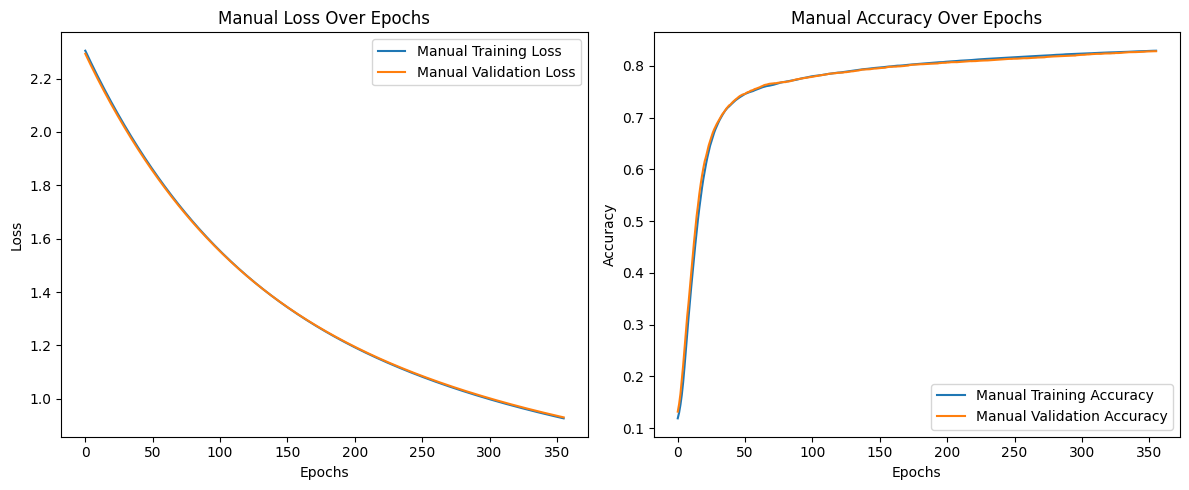

In [46]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_manual, label='Manual Training Loss')
plt.plot(val_losses_manual, label='Manual Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Manual Loss Over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_manual, label='Manual Training Accuracy')
plt.plot(val_accuracies_manual, label='Manual Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Manual Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 6. Test Set Evaluation with Confusion Matrix

In [47]:
# Test set evaluation (add this after training both models)
x_test = x_test_flat[x_test_idx]
y_test_np = y_test_original.numpy()
y_test = y_test_np[x_test_idx]
X_test_t = torch.tensor(x_test, dtype=torch.float32)

# Manual model test eval
with torch.no_grad():
    test_logits = X_test_t @ W_manual + b_manual
    test_preds = test_logits.argmax(dim=1).numpy()
    print("MANUAL: ")
    print(classification_report(y_test, test_preds))

# PyTorch model test eval
with torch.no_grad():
    test_logits = model(X_test_t)
    test_preds_pytorch = test_logits.argmax(dim=1).numpy()
    print("PYTORCH: ")
    print(classification_report(y_test, test_preds_pytorch))

MANUAL: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       980
           1       0.84      0.96      0.90      1135
           2       0.87      0.79      0.83      1032
           3       0.75      0.87      0.81      1010
           4       0.84      0.85      0.84       982
           5       0.91      0.57      0.70       892
           6       0.86      0.91      0.88       958
           7       0.88      0.86      0.87      1028
           8       0.79      0.78      0.78       974
           9       0.81      0.81      0.81      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.84     10000

PYTORCH: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.93      0.96      0.94      1135
           2       0.89      0.83      0.86      1032
     

/tmp/ipython-input-3246308870.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_t = torch.tensor(x_test, dtype=torch.float32)


### 7. Per-Class Accuracy Analysis

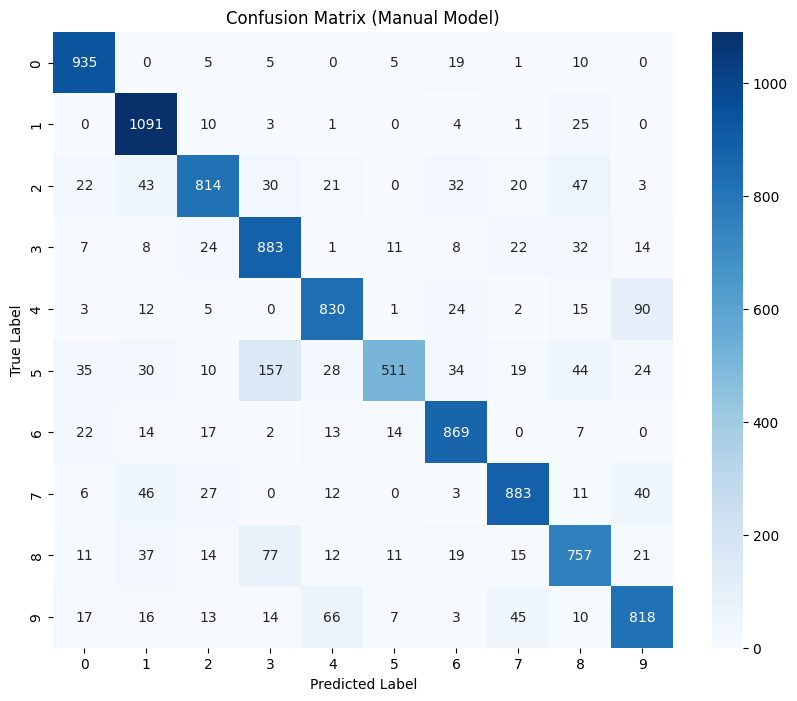

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       980
           1       0.84      0.96      0.90      1135
           2       0.87      0.79      0.83      1032
           3       0.75      0.87      0.81      1010
           4       0.84      0.85      0.84       982
           5       0.91      0.57      0.70       892
           6       0.86      0.91      0.88       958
           7       0.88      0.86      0.87      1028
           8       0.79      0.78      0.78       974
           9       0.81      0.81      0.81      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.84     10000



In [48]:
# Confusion Matrix

cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Manual Model)')
plt.show()

# Classification Report for each class
print(classification_report(
    y_test,
    test_preds,
    target_names=[str(i) for i in range(10)]  # Class names (digits 0-9)
))

# Part B — Custom Feedforward Neural Network (PyTorch)

## B1. Custom Neural Network Architecture

### 1. Implement feedforward neural network using PyTorch
### 2. Minimum architecture: Input → Hidden1 → Hidden2 → Output
### 3. Use ReLU activation for hidden layers
### 4. Flexible architecture allowing easy modification of layers/neurons
### 5. Proper weight initialization (Xavier/He initialization)

In [49]:
class FeedforwardNet(nn.Module):
    # input_dim = number of input features
    # hidden_dims = list of hidden layer dimensions | [256,128]: needed for downscaling from 256 to 128, to avoid overfitting
    # num_classes = number of output classes
    # dropout (Regularization) and use_bn (Normalization) are hyperparameters
    def __init__(self, input_dim=784, hidden_dims=[256, 128], num_classes=10):
        # Inherit from nn.Module, the base class for all Neural Network modules in PyTorch
        super().__init__()

        layers = [] # To collect layer components

        prev = input_dim # Tracks ouput dimension of previous layer

        # enumerate() returns a list of tuples (index of hidden layer, no. of neurons in hidden layer)
        for i,h in enumerate(hidden_dims): # i: index, h: value at i

            # Creates a layer with prev as input and h as output
            layers.append(nn.Linear(prev, h))

            # Applies ReLU
            layers.append(nn.ReLU())

            # Update previous hidden layer
            prev = h

        # Create output layer between 2nd hidden layer and output
        layers.append(nn.Linear(prev, num_classes))

        # Create Sequential model with layers
        self.net = nn.Sequential(*layers)

        # Initialize weights (passing through all layers)
        for m in self.net:
            # Check if m is a Linear Layer, not ReLU
            if isinstance(m, nn.Linear):
                # Initialize weights using Xavier initialization
                nn.init.xavier_uniform_(m.weight)
                # Checks if bias exists
                if m.bias is not None:
                    # Initialize bias with 0
                    nn.init.zeros_(m.bias)

        # nn.init: a function that helps with weight and bias initialization

    def forward(self, x):
        # Check if input is a 4D tensor
        if x.dim() == 4:
            x = x.view(x.size(0), -1) # Reshape to 2D
        return self.net(x) # self.net: Sequential model that contains layers

model = FeedforwardNet(input_dim=784, hidden_dims=[256,128], num_classes=10)
model


FeedforwardNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## B2. Training Infrastructure

### Custom Training Loop Requirements:
#### i. Implement Complete Training Loop from scratch
#### ii. Support for batch processing
#### iii. Proper gradient computation and backpropagation
#### iv. Training/validation split handling

In [66]:
def train_epoch(model, loader, criterion, optimizer, device): # [Part i)]


    # Switches to training mode
    model.train()

    total_loss, total_correct, n = 0.0, 0, 0

    # Loop through batches of data (xb - inputs, yb - targets) [Part ii)]
    for xb, yb in loader:
        xb = xb.view(xb.size(0), -1).to(device)
        yb = yb.to(device)

        # Forward Pass
        logits = model(xb)

        # Calculayte loss between predicted and actual
        # criterion: loss function
        loss = criterion(logits, yb)

        # ******** PART III) ***************

        # Clear old gradients to avoid accumulation
        optimizer.zero_grad()

        # Backpropagate (Calculates gradients of model parameters)
        loss.backward()

        # Update model weights (w = w - lr * gradient)
        optimizer.step()

#          ******** PART III) ***************

        # loss.item(): Average Loss per sample in current batch
        # We multiply by batch size to get total loss
        total_loss += loss.item() * xb.size(0)

        # Calculate accuracy
        preds = logits.argmax(dim=1)

        # Accumulate correct predictions
        total_correct += (preds==yb).sum().item()

        # Update number of samples
        n += xb.size(0)

    return total_loss / n, total_correct / n # Average Loss and Accuracy

def eval_model(model, loader, criterion, device):

    # Switches model to evaluation mode
    model.eval()

    total_loss, total_correct, n = 0.0, 0, 0

    # Disable Gradient Calculation
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.view(xb.size(0), -1).to(device)
            yb = yb.to(device)

            # Forward Pass
            logits = model(xb)

            # Calculate loss function
            loss = criterion(logits, yb)

            # Accumulate total loss
            total_loss += loss.item() * xb.size(0)

            # Take the maximum prediction across class scores (dim = 1) [batch_size, no_of_classes]
            preds = logits.argmax(dim=1)

            # Accumulate correct predictions
            total_correct += (preds==yb).sum().item()

            # Update number of samples
            n += xb.size(0)

    return total_loss / n, total_correct / n # Average Loss and Accuracy


# Part IV) Maintaining Separate train_loader aand val_loader, and different functions [train_epoch, eval_model]

#### v. Progress tracking and logging

In [67]:
model = FeedforwardNet(input_dim=784, hidden_dims=[256,128], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# SGD: Stochastic Gradient Descent
# .parameters(): Returns an iterator over the model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

max_epochs = 100000 # Safety Net
patience = 10
min_delta = 1e-3
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses_new_A, train_accs_new_A = [], []
val_losses_new_A, val_accs_new_A = [], []

for epoch in range(max_epochs):
    # Calculate Loss and Accuracy for Training and Validation Sets
    train_loss, train_acc = train_epoch(model, train_loader_flat, criterion, optimizer, device)
    val_loss, val_acc = eval_model(model, val_loader_flat, criterion, device)

    # Append Losses and Accuracies for Training Sets
    train_losses_new_A.append(train_loss)
    train_accs_new_A.append(train_acc)

    # # Append Losses and Accuracied for Validation Sets
    val_losses_new_A.append(val_loss)
    val_accs_new_A.append(val_acc)

    best_val_loss, epochs_without_improvement = early_stopping_check(val_loss, best_val_loss, patience, min_delta, epochs_without_improvement)

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"Training completed after {epoch} epochs")
print(f"Best validation loss: {best_val_loss:.4f}")

Early stopping at epoch 80
Training completed after 80 epochs
Best validation loss: 0.0832


## B3 - Performance Visualization

### 1. Training and Validation Loss over epochs
### 2. Training and Validation Accuracy over epochs

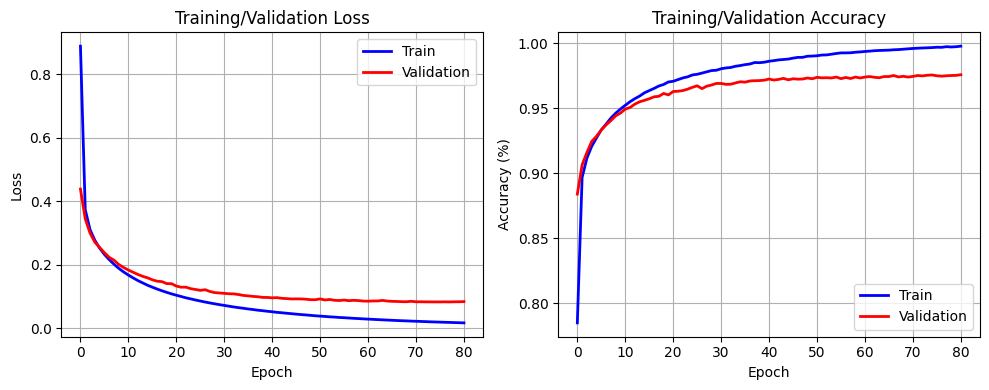

In [68]:
# Loss Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_new_A, 'b-', linewidth=2, label='Train')
plt.plot(val_losses_new_A, 'r-', linewidth=2, label='Validation')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(train_accs_new_A, 'b-', linewidth=2, label='Train')
plt.plot(val_accs_new_A, 'r-', linewidth=2, label='Validation')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3. Learning Curves with error bars

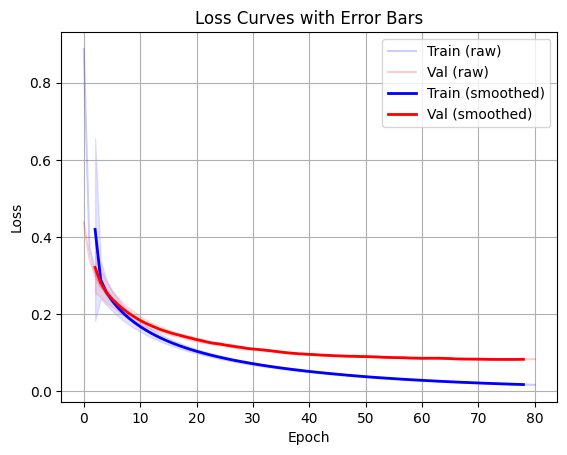

In [69]:
window = 5
train_smooth = np.convolve(train_losses_new_A, np.ones(window)/window, mode='valid')
val_smooth = np.convolve(val_losses_new_A, np.ones(window)/window, mode='valid')

# Plot raw curves
plt.plot(train_losses_new_A, 'b-', alpha=0.2, label='Train (raw)')
plt.plot(val_losses_new_A, 'r-', alpha=0.2, label='Val (raw)')

# Plot smoothed curves with error regions
x_smooth = np.arange(window//2, len(train_losses_new_A)-window//2)
plt.plot(x_smooth, train_smooth, 'b-', linewidth=2, label='Train (smoothed)')
plt.plot(x_smooth, val_smooth, 'r-', linewidth=2, label='Val (smoothed)')

# Error bands (std dev of smoothing window)
train_err = np.array([np.std(train_losses_new_A[i:i+window]) for i in range(len(train_losses_new_A)-window+1)])
val_err = np.array([np.std(val_losses_new_A[i:i+window]) for i in range(len(val_losses_new_A)-window+1)])

plt.fill_between(x_smooth, train_smooth-train_err, train_smooth+train_err, color='blue', alpha=0.1)
plt.fill_between(x_smooth, val_smooth-val_err, val_smooth+val_err, color='red', alpha=0.1)

plt.title('Loss Curves with Error Bars')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

### 4. Convergence Analysis

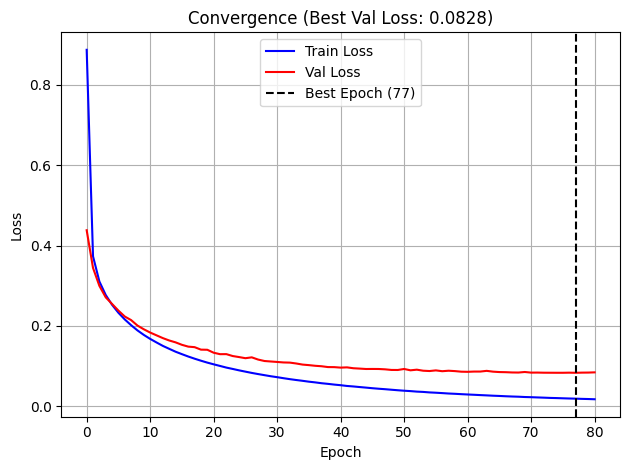

In [70]:
best_epoch = np.argmin(val_losses_new_A)
plt.plot(train_losses_new_A, 'b-', label='Train Loss')
plt.plot(val_losses_new_A, 'r-', label='Val Loss')
plt.axvline(best_epoch, color='k', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title(f'Convergence (Best Val Loss: {min(val_losses_new_A):.4f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Part C - Comprehensive Analysis

### Learning Rate Analysis:
#### 1. Test at least 4 values: [0.001, 0.01, 0.1, 1.0]

In [71]:
def run_experiment(lr, hidden_dims=[128, 64], batch_size=64, n_epochs=10000):
    torch.manual_seed(42)  # Reproducibility
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    vloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = FeedforwardNet(input_dim=784, hidden_dims=hidden_dims, num_classes=10).to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience = 10
    min_delta = 1e-3
    epochs_without_improvement = 0

    train_losses_lr, val_losses_lr = [], []
    train_accs_lr, val_accs_lr = [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, tloader, crit, opt, device)
        train_losses_lr.append(train_loss)
        train_accs_lr.append(train_acc)

        vloss, vacc = eval_model(model, vloader, crit, device)
        val_losses_lr.append(vloss)
        val_accs_lr.append(vacc)

        best_val_loss, epochs_without_improvement = early_stopping_check(vloss, best_val_loss, patience, min_delta, epochs_without_improvement)

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch} for Learning: {lr}")
            break

    return vacc, train_losses_lr, train_accs_lr, val_losses_lr, val_accs_lr

lrs = [0.001, 0.01, 0.1, 1.0]
full_results = {}
lr_accuracies = {}
for lr in lrs:
    print(f"Running experiment with learning rate: {lr}")
    vacc, train_loss, train_acc, val_loss, val_acc = run_experiment(lr=lr)
    full_results[lr] = (train_loss, train_acc, val_loss, val_acc)  # Fixed this line
    lr_accuracies[lr] = vacc

best_lr_acc = max(lr_accuracies, key=lr_accuracies.get)
print(f"Best Learning Rate: {best_lr_acc}, Accuracy: {lr_accuracies[best_lr_acc]}")

Running experiment with learning rate: 0.001
Early stopping at epoch 349 for Learning: 0.001
Running experiment with learning rate: 0.01
Early stopping at epoch 72 for Learning: 0.01
Running experiment with learning rate: 0.1
Early stopping at epoch 20 for Learning: 0.1
Running experiment with learning rate: 1.0
Early stopping at epoch 16 for Learning: 1.0
Best Learning Rate: 0.1, Accuracy: 0.977


#### 2. Plot learning curves for each

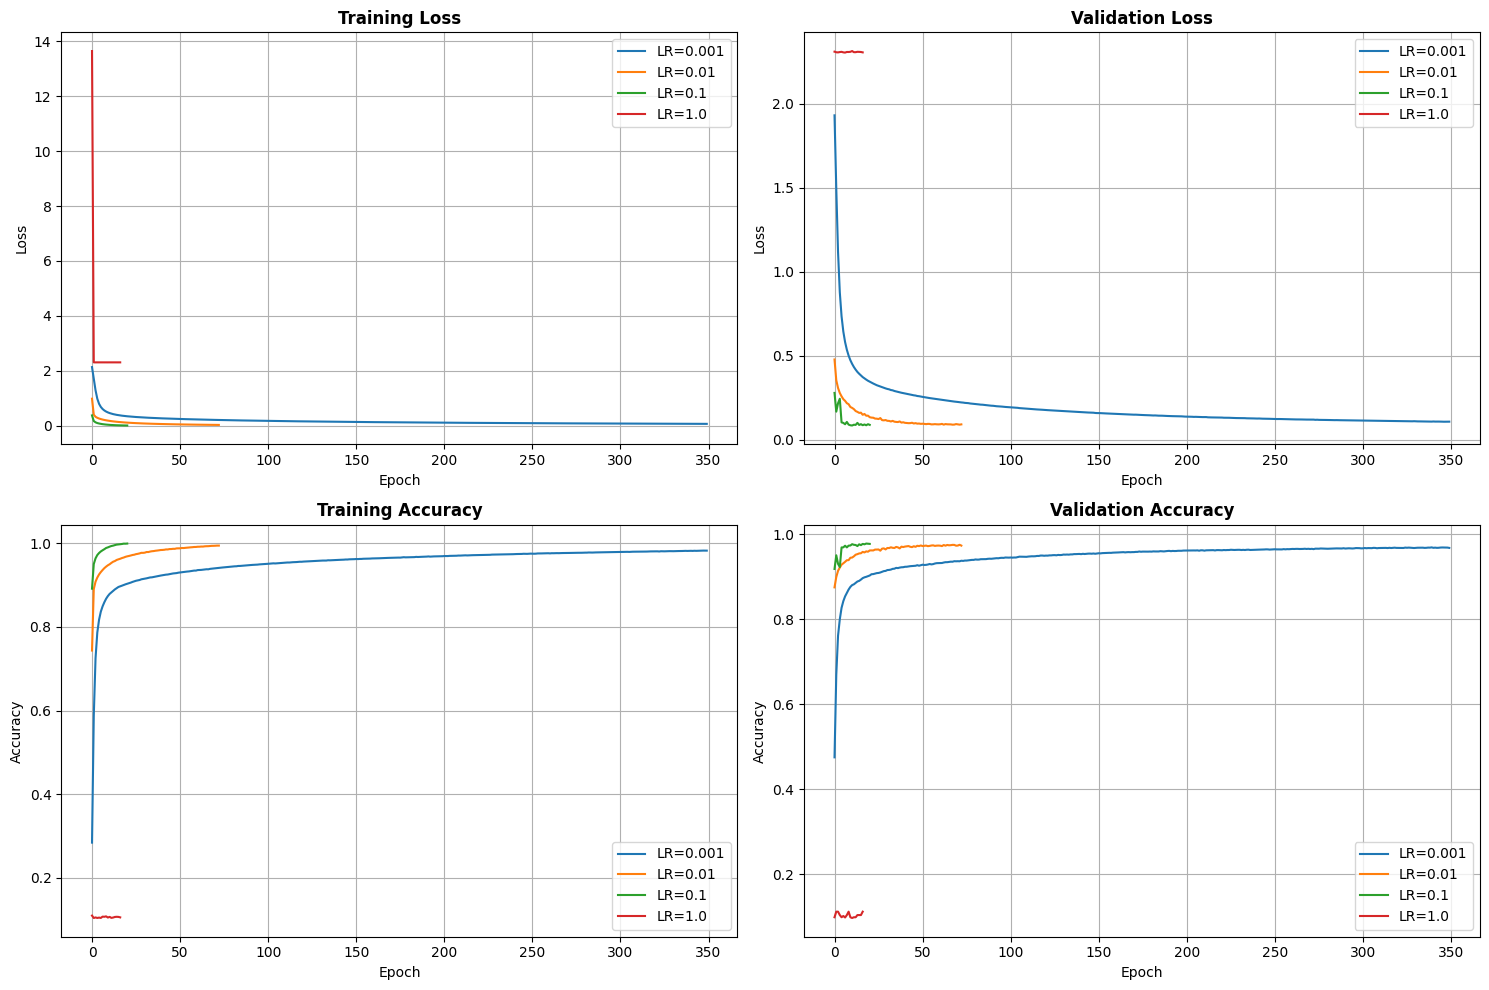

In [72]:
# Plot learning curves
plt.figure(figsize=(15, 10))

# Training Loss
plt.subplot(2, 2, 1)
for lr in lrs:
    plt.plot(full_results[lr][0], label=f'LR={lr}')
plt.title('Training Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation Loss
plt.subplot(2, 2, 2)
for lr in lrs:
    plt.plot(full_results[lr][2], label=f'LR={lr}')
plt.title('Validation Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy
plt.subplot(2, 2, 3)
for lr in lrs:
    plt.plot(full_results[lr][1], label=f'LR={lr}')
plt.title('Training Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Validation Accuracy
plt.subplot(2, 2, 4)
for lr in lrs:
    plt.plot(full_results[lr][3], label=f'LR={lr}')
plt.title('Validation Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### 3. Analyze Convergence speed and stability


CONVERGENCE AND STABILITY ANALYSIS


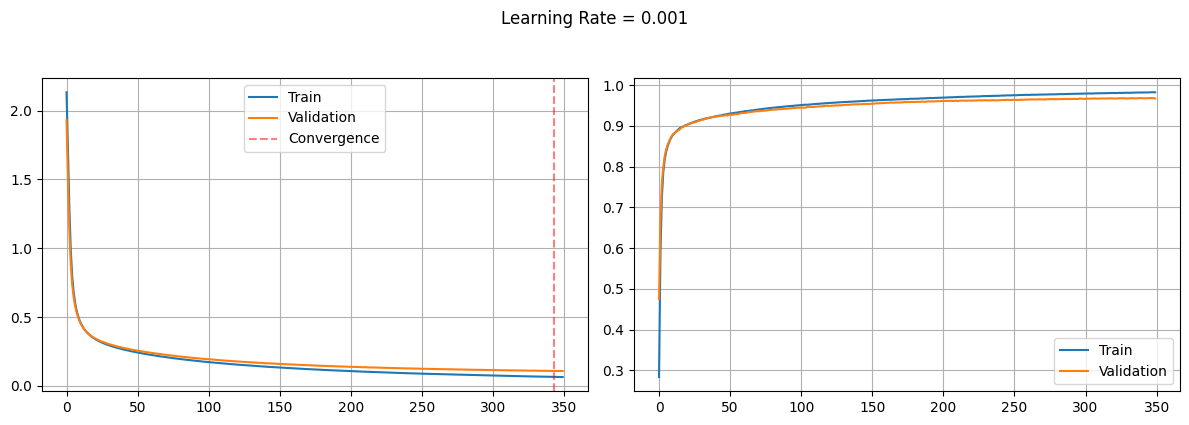


LR = 0.001:
→ Final Val Accuracy: 0.9676
→ Minimum Val Loss: 0.1079
→ Converged at epoch: 343
→ Avg improvement rate: 0.0080
→ Stability metric: 0.0047
--------------------------------------------------


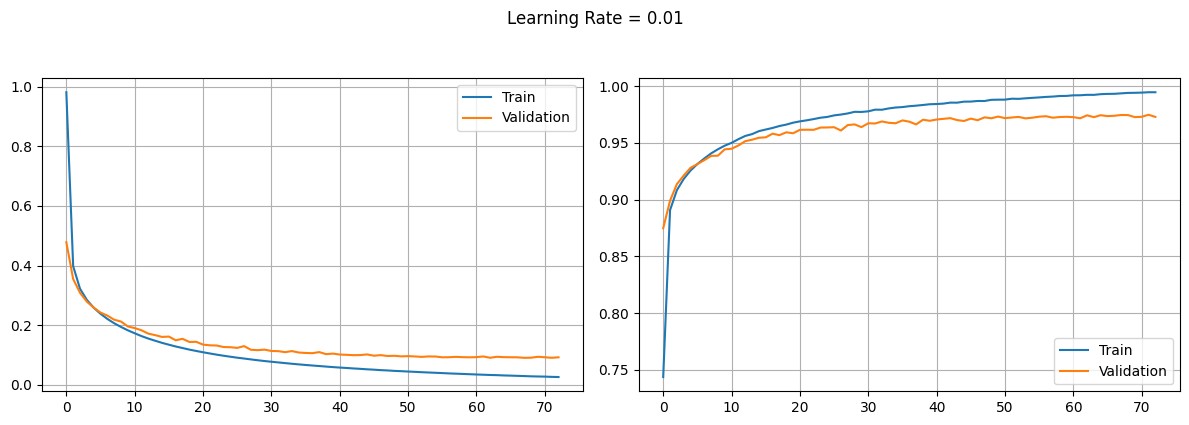


LR = 0.01:
→ Final Val Accuracy: 0.9730
→ Minimum Val Loss: 0.0904
→ Avg improvement rate: 0.0215
→ Stability metric: 0.0247
--------------------------------------------------


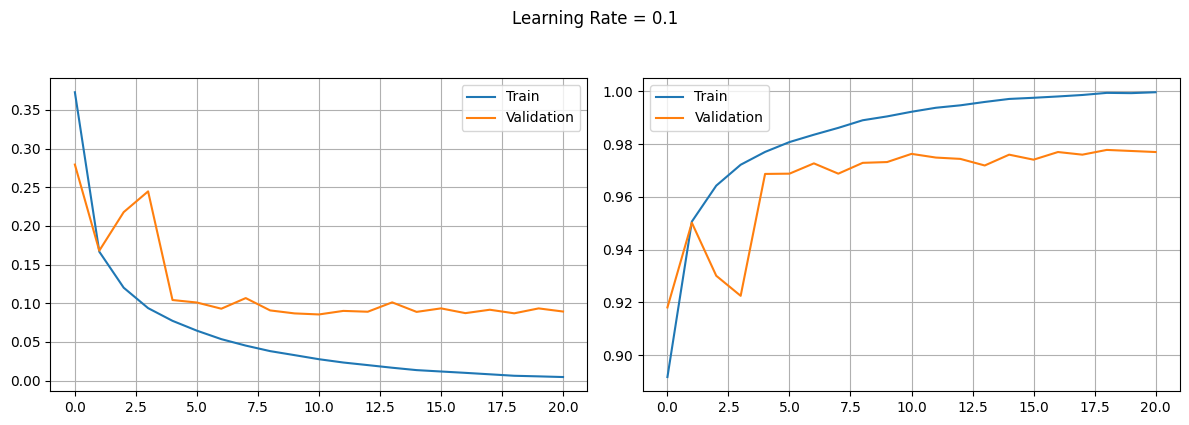


LR = 0.1:
→ Final Val Accuracy: 0.9770
→ Minimum Val Loss: 0.0854
→ Avg improvement rate: 0.0326
→ Stability metric: 0.0657
--------------------------------------------------


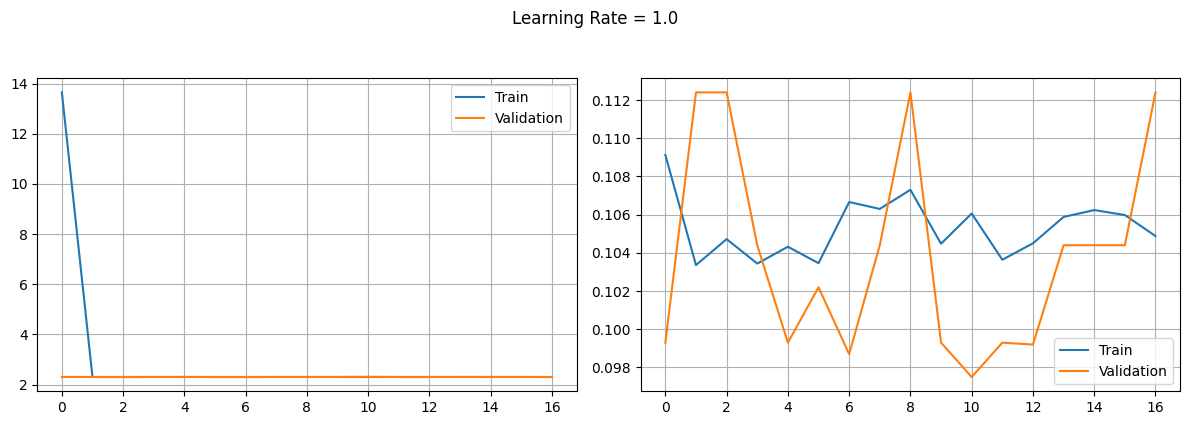


LR = 1.0:
→ Final Val Accuracy: 0.1124
→ Minimum Val Loss: 2.3034
→ No improvement rate available
→ Stability metric: 0.0009
--------------------------------------------------


In [73]:
def analyze_convergence(val_loss_history, threshold=0.01, window=5):
    # Convert tensors to numpy if needed (minimal change)
    val_loss_history = [loss.item() if isinstance(loss, torch.Tensor) else loss
                       for loss in val_loss_history]

    if len(val_loss_history) < window:
        return None, float('nan')

    min_loss = np.min(val_loss_history)
    improvements = []

    for epoch in range(window, len(val_loss_history)):
        max_diff = np.max(val_loss_history[epoch-window:epoch]) - min_loss
        if max_diff < threshold * min_loss:
            convergence_epoch = epoch - window
            pre_conv_loss = val_loss_history[:convergence_epoch]
            if len(pre_conv_loss) > 1:
                improvements = -np.diff(pre_conv_loss) / (np.array(pre_conv_loss[:-1]) + 1e-8)
                avg_improvement = np.mean(improvements)
            else:
                avg_improvement = float('nan')
            return convergence_epoch, avg_improvement

    if len(val_loss_history) > 1:
        improvements = -np.diff(val_loss_history) / (np.array(val_loss_history[:-1]) + 1e-8)
        avg_improvement = np.mean(improvements)
    else:
        avg_improvement = float('nan')
    return None, avg_improvement

def calculate_stability(val_loss_history, warmup=10):
    # Convert tensors to numpy if needed (minimal change)
    val_loss_history = [loss.item() if isinstance(loss, torch.Tensor) else loss
                       for loss in val_loss_history]

    if len(val_loss_history) <= warmup:
        return float('nan')

    stable_period = val_loss_history[warmup:]
    if len(stable_period) < 2:
        return float('nan')

    log_loss = np.log(np.array(stable_period) + 1e-8)
    diffs = np.abs(np.diff(log_loss))
    return np.mean(diffs)

# Main analysis (only change dictionary access)
print("\n" + "="*60)
print("CONVERGENCE AND STABILITY ANALYSIS")
print("="*60)

for lr in lrs:  # Changed from enumerate to direct iteration
    train_loss, train_acc, val_loss, val_acc = full_results[lr]  # Changed from full_results[i]

    conv_epoch, avg_improvement = analyze_convergence(val_loss)
    stability = calculate_stability(val_loss)

    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Learning Rate = {lr}', y=1.05)

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    if conv_epoch:
        plt.axvline(conv_epoch, color='r', linestyle='--', alpha=0.5, label='Convergence')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nLR = {lr}:")
    print(f"→ Final Val Accuracy: {val_acc[-1]:.4f}")
    print(f"→ Minimum Val Loss: {np.min(val_loss):.4f}")
    if conv_epoch:
        print(f"→ Converged at epoch: {conv_epoch}")
    print(f"→ Avg improvement rate: {avg_improvement:.4f}" if not np.isnan(avg_improvement) else "→ No improvement rate available")
    print(f"→ Stability metric: {stability:.4f}" if not np.isnan(stability) else "→ Stability not calculable")
    print("-"*50)

### Batch Size Analysis:

#### 1. Test at least 4 values: [16, 32, 64, 128]

In [74]:
batch_sizes = [16, 32, 64, 128]
batch_results = {}
training_times = {}
train_loss_history = {}
val_acc_history = {}
bs_accuracies = {}

for bs in batch_sizes:
    print(f"Running experiment with batch size: {bs}")
    start_time = time.time()
    batch_results[bs], train_losses_bs, train_accs_bs, val_losses_bs, val_accs_bs = run_experiment(lr=best_lr_acc, batch_size=bs)
    training_times[bs] = time.time() - start_time
    train_loss_history[bs] = train_losses_bs
    val_acc_history[bs] = val_accs_bs
    bs_accuracies[bs] = batch_results[bs]

best_bs_acc =max(bs_accuracies, key=bs_accuracies.get)
print(f"Best Batch Size: ", best_bs_acc, ", Accuracy: ", bs_accuracies[best_bs_acc])

Running experiment with batch size: 16
Early stopping at epoch 16 for Learning: 0.1
Running experiment with batch size: 32
Early stopping at epoch 16 for Learning: 0.1
Running experiment with batch size: 64
Early stopping at epoch 20 for Learning: 0.1
Running experiment with batch size: 128
Early stopping at epoch 28 for Learning: 0.1
Best Batch Size:  32 , Accuracy:  0.9789


#### 2. Compare Training efficiency

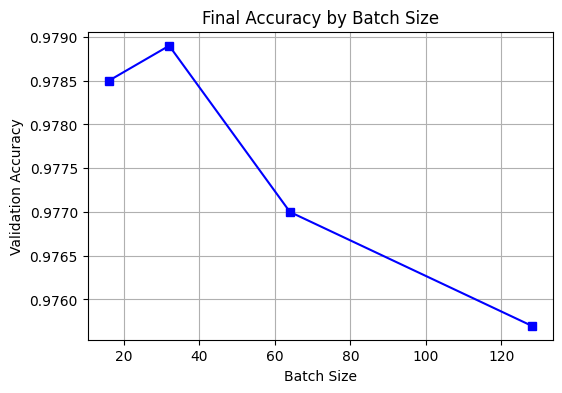

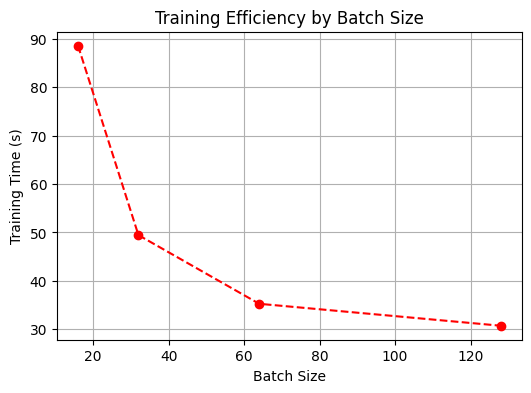

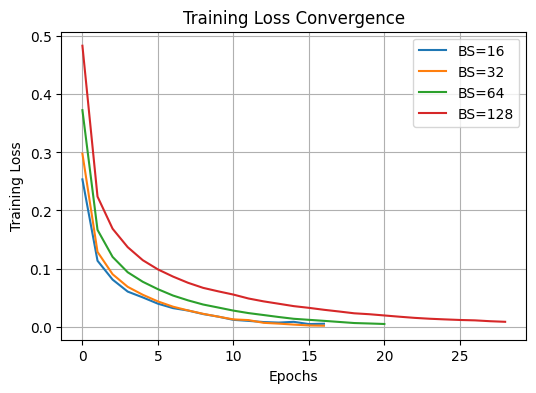

In [75]:
# Plot 1: Final Validation Accuracy vs Batch Size
plt.figure(figsize=(6, 4))
plt.plot(batch_sizes, [batch_results[bs] for bs in batch_sizes], 's-', color='blue')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Final Accuracy by Batch Size')
plt.grid()
plt.show()

# Plot 2: Training Time vs Batch Size
plt.figure(figsize=(6, 4))
plt.plot(batch_sizes, [training_times[bs] for bs in batch_sizes], 'o--', color='red')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (s)')
plt.title('Training Efficiency by Batch Size')
plt.grid()
plt.show()

# Plot 3: Training Loss Curves (Convergence Speed)
plt.figure(figsize=(6, 4))
for bs in batch_sizes:
    plt.plot(train_loss_history[bs], label=f'BS={bs}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Convergence')
plt.legend()
plt.grid()
plt.show()

#### 3. Compare Final Performance

=== Final Performance Comparison ===
|   Batch Size |   Training Time (s) |   Final Val Accuracy |   Final Train Loss |   Acc/Time |
|-------------:|--------------------:|---------------------:|-------------------:|-----------:|
|           16 |             88.552  |               0.9785 |         0.0048953  |  0.01105   |
|           32 |             49.4478 |               0.9789 |         0.00148716 |  0.0197966 |
|           64 |             35.2668 |               0.977  |         0.0044787  |  0.0277031 |
|          128 |             30.738  |               0.9757 |         0.0082412  |  0.0317424 |


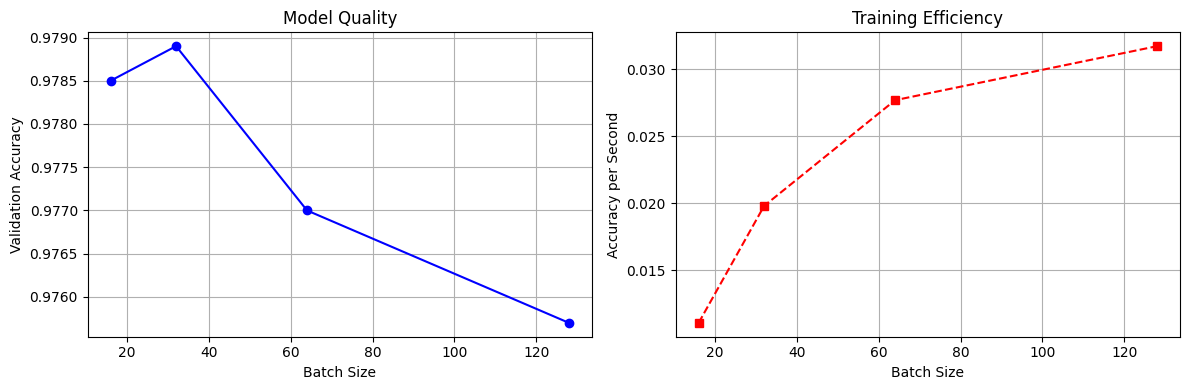

In [76]:
# Create comparison table
comparison = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Training Time (s)': [training_times[bs] for bs in batch_sizes],
    'Final Val Accuracy': [batch_results[bs] for bs in batch_sizes],
    'Final Train Loss': [train_loss_history[bs][-1] for bs in batch_sizes]  # Last epoch loss
})

# Add efficiency metric (accuracy per second)
comparison['Acc/Time'] = comparison['Final Val Accuracy'] / comparison['Training Time (s)']

print("=== Final Performance Comparison ===")
print(comparison.to_markdown(index=False))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Accuracy vs Batch Size
ax1.plot(batch_sizes, comparison['Final Val Accuracy'], 'bo-')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Model Quality')
ax1.grid()

# Plot 2: Efficiency (Accuracy/Time)
ax2.plot(batch_sizes, comparison['Acc/Time'], 'rs--')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Accuracy per Second')
ax2.set_title('Training Efficiency')
ax2.grid()

plt.tight_layout()
plt.show()

#### 4. Analyze effect on Gradient Noise

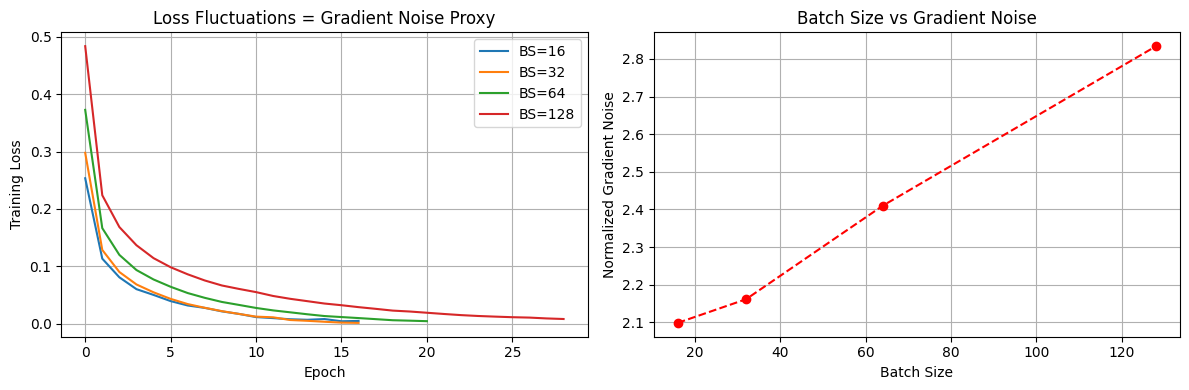


Key Observations:
1. Small batches (16): Highest noise (2.0989) 
2. Large batches (128): Lowest noise (2.8337) 


In [77]:
def estimate_gradient_noise(loss_history):

    losses = np.array(loss_history)
    rolling_diff = np.abs(losses[1:] - losses[:-1])  # Approximate gradient magnitude changes
    return np.std(rolling_diff) / np.mean(rolling_diff)  # Normalized noise metric

# Analyze noise for each batch size
plt.figure(figsize=(12, 4))

# Plot 1: Training Loss Fluctuations (Proxy for Gradient Noise)
plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(train_loss_history[bs], label=f'BS={bs}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Fluctuations = Gradient Noise Proxy')
plt.legend()
plt.grid()

# Plot 2: Quantitative Noise Comparison
plt.subplot(1, 2, 2)
noise_levels = [estimate_gradient_noise(train_loss_history[bs]) for bs in batch_sizes]
plt.plot(batch_sizes, noise_levels, 'ro--')
plt.xlabel('Batch Size')
plt.ylabel('Normalized Gradient Noise')
plt.title('Batch Size vs Gradient Noise')
plt.grid()

plt.tight_layout()
plt.show()

# Print key insights
print("\nKey Observations:")
print(f"1. Small batches (16): Highest noise ({noise_levels[0]:.4f}) ")
print(f"2. Large batches (128): Lowest noise ({noise_levels[-1]:.4f}) ")


### Architecure Analysis:

#### 1. Number of layers: Test 2, 3, 4, 5 hidden layers
#### 2. Neurons per layer: Test [64, 128, 256, 512] neurons
#### 3. Create architecture comparison table

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Define architectures to test
architectures = {
    '2_layers_64': [64, 32],
    '2_layers_128': [128, 64],
    '2_layers_256': [256, 128],
    '2_layers_512': [512, 256],

    '3_layers_64': [64, 32, 16],
    '3_layers_128': [128, 64, 32],
    '3_layers_256': [256, 128, 64],
    '3_layers_512': [512, 256, 128],

    '4_layers_64': [64, 32, 16, 8],
    '4_layers_128': [128, 64, 32, 16],
    '4_layers_256': [256, 128, 64, 32],
    '4_layers_512': [512, 256, 128, 64],

    '5_layers_64': [64, 32, 16, 8, 4],
    '5_layers_128': [128, 64, 32, 16, 8],
    '5_layers_256': [256, 128, 64, 32, 16],
    '5_layers_512': [512, 256, 128, 64, 32]
}

def calculate_params(hidden_dims, input_dim=784, output_dim=10):
    total = input_dim * hidden_dims[0] + hidden_dims[0]  # input → first hidden
    for i in range(1, len(hidden_dims)):
        total += hidden_dims[i-1] * hidden_dims[i] + hidden_dims[i]
    total += hidden_dims[-1] * output_dim + output_dim  # last hidden → output
    return total

# Run experiments
arch_results = {}
for name, arch in architectures.items():
    print(f'Testing {name}: {arch}')

    vacc, train_losses, train_accs, val_losses, val_accs = run_experiment(
        lr=0.01, hidden_dims=arch, n_epochs=200)

    arch_results[name] = {
        'accuracy': float(vacc),
        'n_layers': len(arch),
        'max_neurons': max(arch),
        'total_params': calculate_params(arch)
    }

# Find best architecture by accuracy
best_arch = max(arch_results, key=lambda x: arch_results[x]['accuracy'])
print(f"\n Best Architecture: {best_arch} → {arch_results[best_arch]['accuracy']:.4f}")

# Convert results to DataFrame
df_arch = pd.DataFrame.from_dict(arch_results, orient='index')
df_arch = df_arch.sort_values('accuracy', ascending=False)
print("\n Architecture Comparison:")
print(df_arch[['n_layers', 'max_neurons', 'total_params', 'accuracy']].to_markdown())


Testing 2_layers_64: [64, 32]
Early stopping at epoch 80 for Learning: 0.01
Testing 2_layers_128: [128, 64]
Early stopping at epoch 72 for Learning: 0.01
Testing 2_layers_256: [256, 128]
Early stopping at epoch 80 for Learning: 0.01
Testing 2_layers_512: [512, 256]
Early stopping at epoch 82 for Learning: 0.01
Testing 3_layers_64: [64, 32, 16]
Early stopping at epoch 53 for Learning: 0.01
Testing 3_layers_128: [128, 64, 32]
Early stopping at epoch 54 for Learning: 0.01
Testing 3_layers_256: [256, 128, 64]
Early stopping at epoch 57 for Learning: 0.01
Testing 3_layers_512: [512, 256, 128]
Early stopping at epoch 49 for Learning: 0.01
Testing 4_layers_64: [64, 32, 16, 8]
Early stopping at epoch 34 for Learning: 0.01
Testing 4_layers_128: [128, 64, 32, 16]
Early stopping at epoch 43 for Learning: 0.01
Testing 4_layers_256: [256, 128, 64, 32]
Early stopping at epoch 39 for Learning: 0.01
Testing 4_layers_512: [512, 256, 128, 64]
Early stopping at epoch 35 for Learning: 0.01
Testing 5_layer

## C2. Model Comparison

### Comparative Analysis:

#### 1. Compare logistic regression, softmax regression, and best neural network

In [79]:
list(arch_results.values())[0]


{'accuracy': 0.9706, 'n_layers': 2, 'max_neurons': 64, 'total_params': 52650}

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Prepare flattened data
X_TRAIN_FLAT_NEW = train_dataset_flat.tensors[0].numpy()
Y_TRAIN_FLAT_NEW = train_dataset_flat.tensors[1].numpy()
X_VALIDATION_FLAT_NEW = val_dataset_flat.tensors[0].numpy()
Y_VALIDATION_FLAT_NEW = val_dataset_flat.tensors[1].numpy()

# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_TRAIN_FLAT_NEW, Y_TRAIN_FLAT_NEW)
lr_acc = accuracy_score(Y_VALIDATION_FLAT_NEW, lr_model.predict(X_VALIDATION_FLAT_NEW))

# 2. Softmax Regression (multinomial logistic regression)
softmax_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
softmax_model.fit(X_TRAIN_FLAT_NEW, Y_TRAIN_FLAT_NEW)
softmax_acc = accuracy_score(Y_VALIDATION_FLAT_NEW, softmax_model.predict(X_VALIDATION_FLAT_NEW))

# 3. Best Neural Network results from earlier runs
best_nn_val_acc = max([result['accuracy'] for result in arch_results.values()])

# Create comparison table
comparison = {
    'Logistic Regression': lr_acc,
    'Softmax Regression': softmax_acc,
    'Best Neural Network': best_nn_val_acc
}

# Display neatly
comparison_df = pd.DataFrame.from_dict(comparison, orient='index', columns=['Validation Accuracy'])
comparison_df

# Logistic = Softmax because it is a binary classification


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Validation Accuracy
Logistic Regression,0.9222
Softmax Regression,0.9222
Best Neural Network,0.9774


#### 2. Analyze Computational Complexity and Training Time

##### a) Logistic Regression:

In [82]:
# Analyze computational complexity and training time

# Compute training time for Logistic Regression
start_time = time.time()
lr_model.fit(X_TRAIN_FLAT_NEW, Y_TRAIN_FLAT_NEW)
end_time = time.time()
lr_time = end_time - start_time

# Compute computational complexity for Logistic Regression
lr_complexity = lr_model.coef_.shape[0] * lr_model.coef_.shape[1]

print("Logistic Regression: \n")
print("Training Time: {:.2f} seconds".format(lr_time))
print("Computational Complexity: {:.2f} parameters".format(lr_complexity))


Logistic Regression: 

Training Time: 63.31 seconds
Computational Complexity: 7840.00 parameters


##### b) Softmax Regression

In [83]:

# Compute training time for Softmax Regression
W = torch.zeros(D, K, dtype=torch.float32, requires_grad=False)
b = torch.zeros(K, dtype=torch.float32, requires_grad=False)
X_t = torch.tensor(x_soft, dtype=torch.float32)
y_t = torch.tensor(y_soft, dtype=torch.long)
start_time = time.time()

softmax_manual(X_t, y_t, W, b, lr=0.01, max_epochs=1000)
end_time = time.time()
softmax_time = end_time - start_time

# Compute computational complexity for Softmax Regression
softmax_complexity = D * K

print("\nSoftmax Regression: \n")
print("Training Time: {:.2f} seconds".format(softmax_time))
print("Computational Complexity: {:.2f} parameters".format(softmax_complexity))

/tmp/ipython-input-157883632.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t = torch.tensor(x_soft, dtype=torch.float32)



Softmax Regression: 

Training Time: 84.17 seconds
Computational Complexity: 7840.00 parameters


##### c) Neural Network

In [92]:
# Compute training time for Neural Network
start_time = time.time()
best_lr, _ = max(full_results.items(), key=lambda x: max(x[1][-1]))  # use highest val_acc

best_arch_key, arch_data = max(arch_results.items(), key=lambda x: x[1]['accuracy'])

if isinstance(best_arch_key, tuple):
    hidden_dims = list(best_arch_key)
else:
    hidden_dims = [best_arch_key]

print("Best hidden_dims:", hidden_dims)



Our_NN_model = FeedforwardNet(input_dim=784, hidden_dims=hidden_dims, num_classes=10)

opt = torch.optim.SGD(Our_NN_model.parameters(), lr=best_lr)
crit = nn.CrossEntropyLoss()

for epoch in range(max_epochs):
    train_epoch(Our_NN_model, train_loader, crit, opt, device='cpu')

    best_val_loss, epochs_without_improvement = early_stopping_check(Our_NN_model, val_loader, crit, opt, device='cpu')
    if epochs_without_improvement > patience:
        break


end_time = time.time()
nn_time = end_time - start_time

# Compute computational complexity for Neural Network
nn_complexity = sum([param.numel() for param in Our_NN_model.parameters()])


print("\nNeural Network: \n")
print("Training Time: {:.2f} seconds".format(nn_time))
print("Computational Complexity: {:.2f} parameters".format(nn_complexity))



Best hidden_dims: ['2_layers_256']


ValueError: invalid literal for int() with base 10: '2_layers_256'

#### Best Model Evaluation

In [93]:
res_models = {
    "Logistic Regression": lr_acc,
    "Softmax Regression": softmax_acc,
    "Best Neural Network": best_nn_val_acc
}

best_model_name = max(res_models, key=res_models.get)
print("Validation Results:", res_models)
print("Best model based on validation:", best_model_name)

if best_model_name == "Logistic Regression":
    best_model = lr_model
elif best_model_name == "Softmax Regression":
    best_model = softmax_model
elif best_model_name == "Best Neural Network":
    best_model = model
else:
    raise ValueError("Invalid model name")

Validation Results: {'Logistic Regression': 0.9222, 'Softmax Regression': 0.9222, 'Best Neural Network': 0.9774}
Best model based on validation: Best Neural Network


##### 1. Test Optimal Configuration on test set

In [94]:
best_model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test_flat.numpy(), dtype=torch.float32).to(device)
    y_test_tensor = y_test_original.to(device)

    outputs = best_model(x_test_tensor)
    _, y_pred = torch.max(outputs, 1)

##### 2. Report Final Accuracy and Detailed Confusion Matrix

Final Test Accuracy: 0.9770


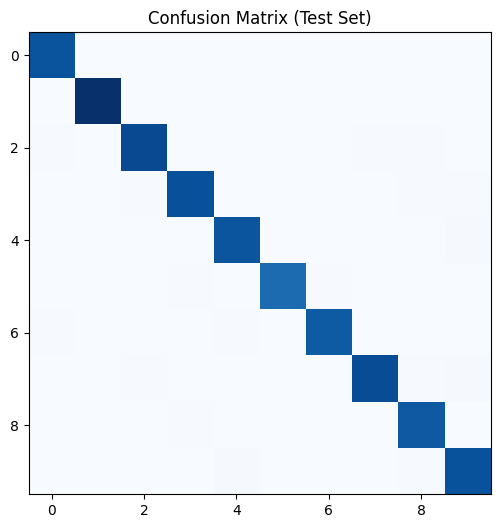

In [97]:
test_acc = accuracy_score(y_test_tensor.cpu(), y_pred.cpu())
print(f"Final Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test_tensor.cpu(), y_pred.cpu())

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

##### 3. Analyze Misclassified Examples

Number of misclassified examples: 230


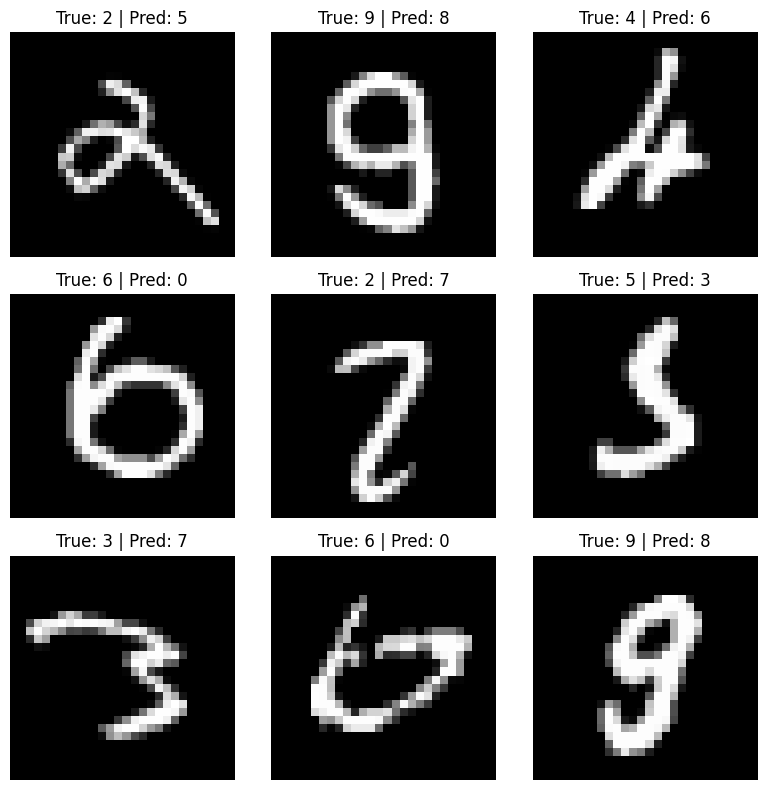

In [98]:
mis_idx = (y_pred != y_test_tensor).nonzero(as_tuple=True)[0]

print(f"Number of misclassified examples: {len(mis_idx)}")

# Show first 9 misclassified examples
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < len(mis_idx):
        idx = mis_idx[i].item()
        ax.imshow(x_test_original[idx].cpu(), cmap="gray")
        ax.set_title(f"True: {y_test_original[idx].item()} | Pred: {y_pred[idx].item()}")
        ax.axis("off")
plt.tight_layout()
plt.show()

## Part D - Advanced Techniques (Bonus)

### D1. Convolutional Neural Networks

#### 1. Implement Basic CNN architecture for MNIST

In [100]:
# Define the CNN architecture
class SimpleCNN(nn.Module): # A simple CNN for MNIST classification
    def __init__(self, num_classes=10, dropout=0.0, use_bn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # Input channels = 1 (grayscale), output channels = 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #input channels = 16, output channels = 32
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling : reduces spatial dimensions by half
        self.use_bn = use_bn # Flag to use Batch Normalization: if True, apply BN after each conv layer
        if use_bn:
            self.bn1 = nn.BatchNorm2d(16) # BatchNorm for 16 output channels
            self.bn2 = nn.BatchNorm2d(32) # BatchNorm for 32 output channels
        self.dropout = nn.Dropout(dropout) # # Dropout layer for regularization
        self.fc = nn.Linear(32 * 7 * 7, num_classes)  # 28x28 -> 14x14 -> 7x7 after two max pools

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(x)
        return self.fc(x)

# Training function
def train_epoch_2(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Evaluation function
def eval_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = SimpleCNN(num_classes=10, dropout=0.2, use_bn=True).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001) # Adam optimizer: adaptive learning rate
criterion = nn.CrossEntropyLoss()

# Train for one epoch
print('Running one epoch of CNN (demo)')
train_loss, train_acc = train_epoch_2(cnn, train_loader, criterion, optimizer, device)
val_loss, val_acc = eval_model(cnn, val_loader, criterion, device)

print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Running one epoch of CNN (demo)
Train Loss: 0.1569, Train Acc: 95.28%
Val Loss: 0.0541, Val Acc: 98.32%


#### 2. Compare CNN vs fully connected network performance

Epoch 1/5 | CNN Val Acc: 97.68% | FCN Val Acc: 96.77%
Epoch 2/5 | CNN Val Acc: 98.66% | FCN Val Acc: 97.13%
Epoch 3/5 | CNN Val Acc: 98.38% | FCN Val Acc: 97.45%
Epoch 4/5 | CNN Val Acc: 98.93% | FCN Val Acc: 98.05%
Epoch 5/5 | CNN Val Acc: 98.74% | FCN Val Acc: 97.98%


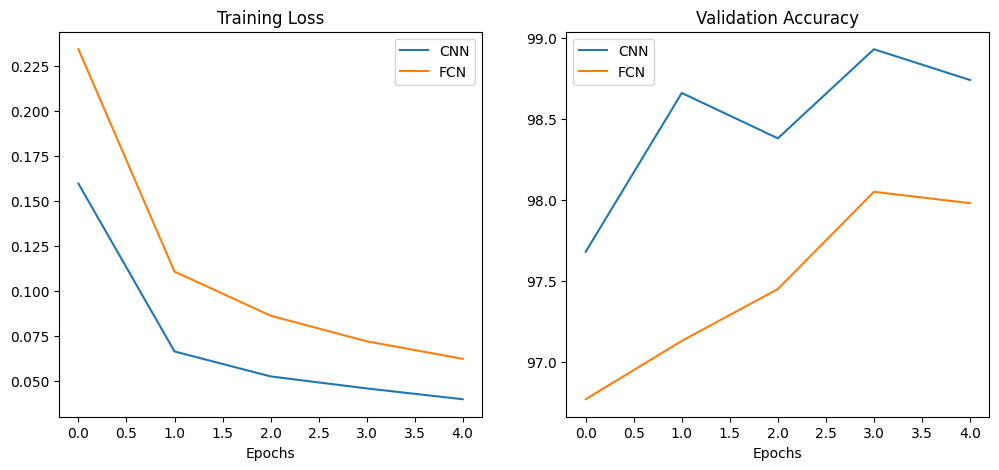


Final Comparison:
CNN Best Val Accuracy: 98.93%
FCN Best Val Accuracy: 98.05%
Parameter Count - CNN: 20,490
Parameter Count - FCN: 535,818


In [101]:
# Fully Connected Network (MLP) for comparison
class SimpleFCN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# Training and comparison function
def compare_models(epochs=5):
    # Initialize both models
    cnn = SimpleCNN(num_classes=10, dropout=0.2, use_bn=True).to(device)
    fcn = SimpleFCN(num_classes=10, dropout=0.2).to(device)

    # Shared training setup
    criterion = nn.CrossEntropyLoss()
    cnn_optim = torch.optim.Adam(cnn.parameters(), lr=0.001)
    fcn_optim = torch.optim.Adam(fcn.parameters(), lr=0.001)

    # Track metrics
    results = {
        'CNN': {'train_loss': [], 'val_acc': []},
        'FCN': {'train_loss': [], 'val_acc': []}
    }

    # Training loop
    for epoch in range(epochs):
        # Train CNN
        cnn.train()
        train_loss, _ = train_epoch_2(cnn, train_loader, criterion, cnn_optim, device)
        _, val_acc = eval_model(cnn, val_loader, criterion, device)
        results['CNN']['train_loss'].append(train_loss)
        results['CNN']['val_acc'].append(val_acc)

        # Train FCN
        fcn.train()
        train_loss, _ = train_epoch_2(fcn, train_loader, criterion, fcn_optim, device)
        _, val_acc = eval_model(fcn, val_loader, criterion, device)
        results['FCN']['train_loss'].append(train_loss)
        results['FCN']['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs} | CNN Val Acc: {results["CNN"]["val_acc"][-1]:.2f}% | FCN Val Acc: {results["FCN"]["val_acc"][-1]:.2f}%')

    return results

# Run comparison
results = compare_models(epochs=5)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['CNN']['train_loss'], label='CNN')
plt.plot(results['FCN']['train_loss'], label='FCN')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['CNN']['val_acc'], label='CNN')
plt.plot(results['FCN']['val_acc'], label='FCN')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Final evaluation
print("\nFinal Comparison:")
print(f"CNN Best Val Accuracy: {max(results['CNN']['val_acc']):.2f}%")
print(f"FCN Best Val Accuracy: {max(results['FCN']['val_acc']):.2f}%")
print(f"Parameter Count - CNN: {sum(p.numel() for p in SimpleCNN().parameters()):,}")
print(f"Parameter Count - FCN: {sum(p.numel() for p in SimpleFCN().parameters()):,}")

### D2. Regularization Techniques

#### 1. Dropout Analysis (Implement Dropout layers with different rates [0.1,0.3,0.5,0.7])


=== Training with dropout rate: 0.1 ===
Epoch 1/10 | Train Loss: 0.1452 | Val Loss: 0.0635 | Train Acc: 95.72% | Val Acc: 97.81%
Epoch 2/10 | Train Loss: 0.0593 | Val Loss: 0.0445 | Train Acc: 98.13% | Val Acc: 98.70%
Epoch 3/10 | Train Loss: 0.0444 | Val Loss: 0.0455 | Train Acc: 98.58% | Val Acc: 98.66%
Epoch 4/10 | Train Loss: 0.0400 | Val Loss: 0.0403 | Train Acc: 98.72% | Val Acc: 98.81%
Epoch 5/10 | Train Loss: 0.0328 | Val Loss: 0.0314 | Train Acc: 98.93% | Val Acc: 98.98%
Epoch 6/10 | Train Loss: 0.0295 | Val Loss: 0.0295 | Train Acc: 99.03% | Val Acc: 99.02%
Epoch 7/10 | Train Loss: 0.0254 | Val Loss: 0.0370 | Train Acc: 99.14% | Val Acc: 98.83%
Epoch 8/10 | Train Loss: 0.0228 | Val Loss: 0.0391 | Train Acc: 99.26% | Val Acc: 98.82%
Epoch 9/10 | Train Loss: 0.0217 | Val Loss: 0.0307 | Train Acc: 99.28% | Val Acc: 99.13%
Epoch 10/10 | Train Loss: 0.0198 | Val Loss: 0.0304 | Train Acc: 99.33% | Val Acc: 99.04%

=== Training with dropout rate: 0.3 ===
Epoch 1/10 | Train Loss: 0.

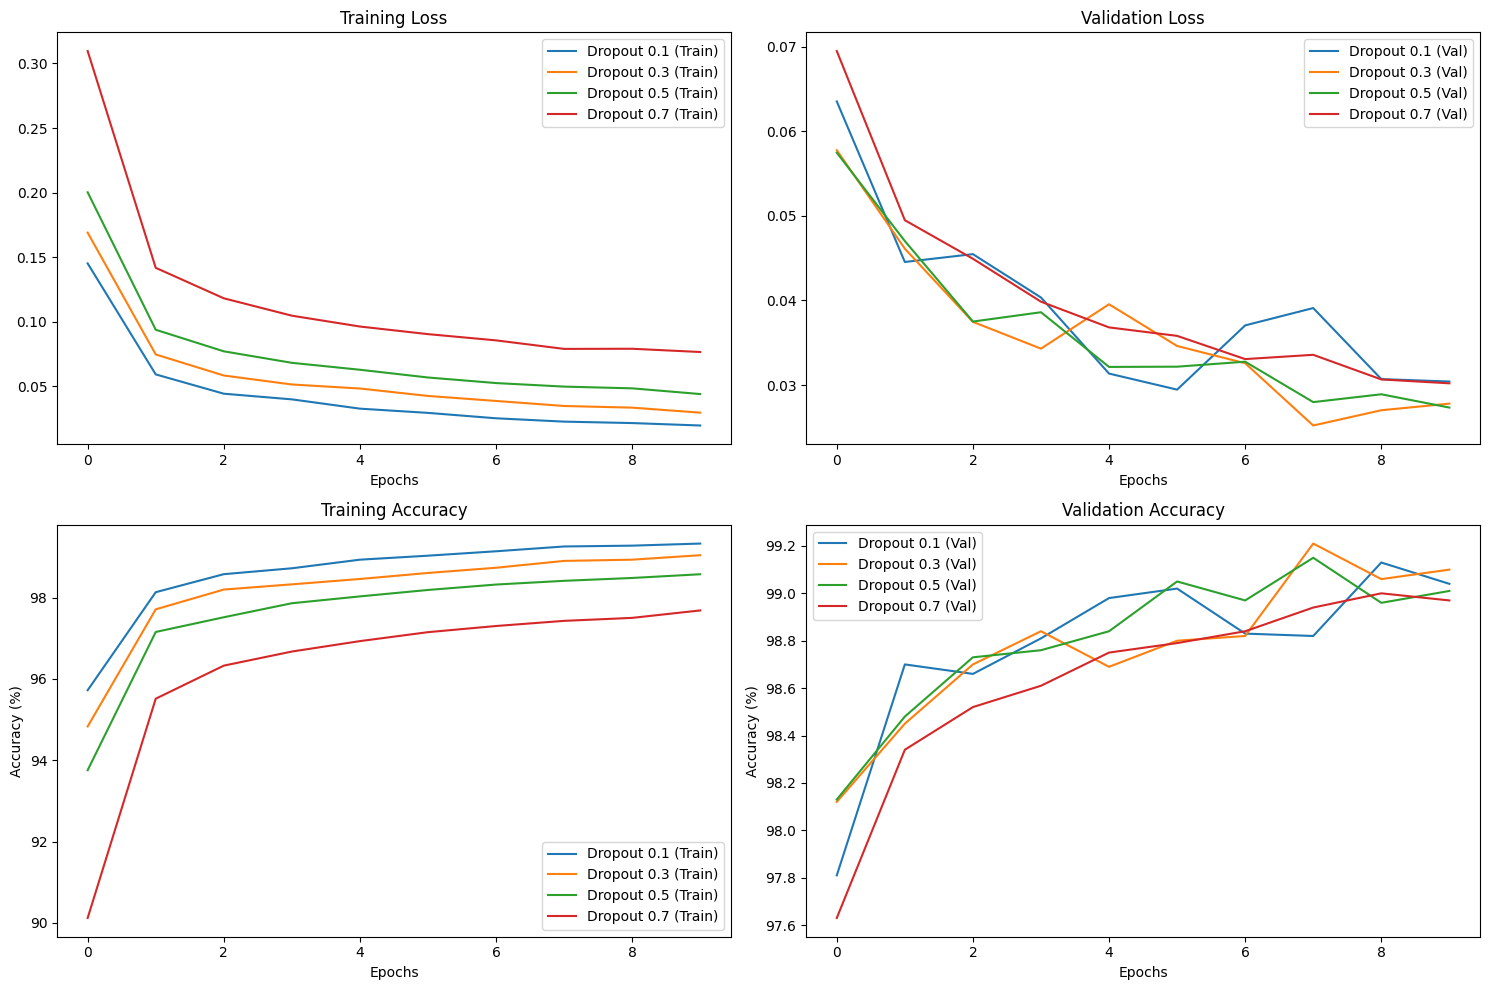


Final Validation Accuracies:
Dropout 0.1: 99.04% (Train-Val gap: 0.29%)
Dropout 0.3: 99.10% (Train-Val gap: -0.06%)
Dropout 0.5: 99.01% (Train-Val gap: -0.44%)
Dropout 0.7: 98.97% (Train-Val gap: -1.28%)


In [102]:
def dropout_analysis(dropout_rates=[0.1, 0.3, 0.5, 0.7], epochs=10): # Droput: regularization technique to prevent overfitting
    results = {}

    for rate in dropout_rates:
        print(f"\n=== Training with dropout rate: {rate} ===")

        # Initialize model with current dropout rate
        model = SimpleCNN(num_classes=10, dropout=rate, use_bn=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Track metrics
        metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

        for epoch in range(epochs):
            # Train
            train_loss, train_acc = train_epoch_2(model, train_loader, criterion, optimizer, device)
            # Evaluate
            val_loss, val_acc = eval_model(model, val_loader, criterion, device)

            metrics['train_loss'].append(train_loss)
            metrics['val_loss'].append(val_loss)
            metrics['train_acc'].append(train_acc)
            metrics['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        results[rate] = metrics

    # Visualization
    plt.figure(figsize=(15, 10))

    # Loss plot
    plt.subplot(2, 2, 1)
    for rate, data in results.items():
        plt.plot(data['train_loss'], label=f'Dropout {rate} (Train)')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 2)
    for rate, data in results.items():
        plt.plot(data['val_loss'], label=f'Dropout {rate} (Val)')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 2, 3)
    for rate, data in results.items():
        plt.plot(data['train_acc'], label=f'Dropout {rate} (Train)')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(2, 2, 4)
    for rate, data in results.items():
        plt.plot(data['val_acc'], label=f'Dropout {rate} (Val)')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final comparison
    print("\nFinal Validation Accuracies:")
    for rate in dropout_rates:
        final_acc = results[rate]['val_acc'][-1]
        gap = results[rate]['train_acc'][-1] - final_acc
        print(f"Dropout {rate}: {final_acc:.2f}% (Train-Val gap: {gap:.2f}%)")

# Run the analysis
dropout_analysis()

#### 2. Batch Normalization


=== Training: No BN, No Dropout ===
Epoch 1/10 | Train Loss: 0.0565 | Val Loss: 0.0388 | Grad Norm: 3.14
Epoch 2/10 | Train Loss: 0.0329 | Val Loss: 0.0421 | Grad Norm: 2.13
Epoch 3/10 | Train Loss: 0.0229 | Val Loss: 0.0342 | Grad Norm: 3.06
Epoch 4/10 | Train Loss: 0.0167 | Val Loss: 0.0376 | Grad Norm: 0.24
Epoch 5/10 | Train Loss: 0.0110 | Val Loss: 0.0407 | Grad Norm: 0.19
Epoch 6/10 | Train Loss: 0.0090 | Val Loss: 0.0412 | Grad Norm: 0.01
Epoch 7/10 | Train Loss: 0.0067 | Val Loss: 0.0435 | Grad Norm: 0.00
Epoch 8/10 | Train Loss: 0.0046 | Val Loss: 0.0552 | Grad Norm: 0.01
Epoch 9/10 | Train Loss: 0.0049 | Val Loss: 0.0540 | Grad Norm: 0.00
Epoch 10/10 | Train Loss: 0.0054 | Val Loss: 0.0564 | Grad Norm: 2.59

=== Training: BN Only ===
Epoch 1/10 | Train Loss: 0.0524 | Val Loss: 0.0484 | Grad Norm: 1.84
Epoch 2/10 | Train Loss: 0.0340 | Val Loss: 0.0400 | Grad Norm: 0.19
Epoch 3/10 | Train Loss: 0.0228 | Val Loss: 0.0389 | Grad Norm: 0.49
Epoch 4/10 | Train Loss: 0.0179 | Val 

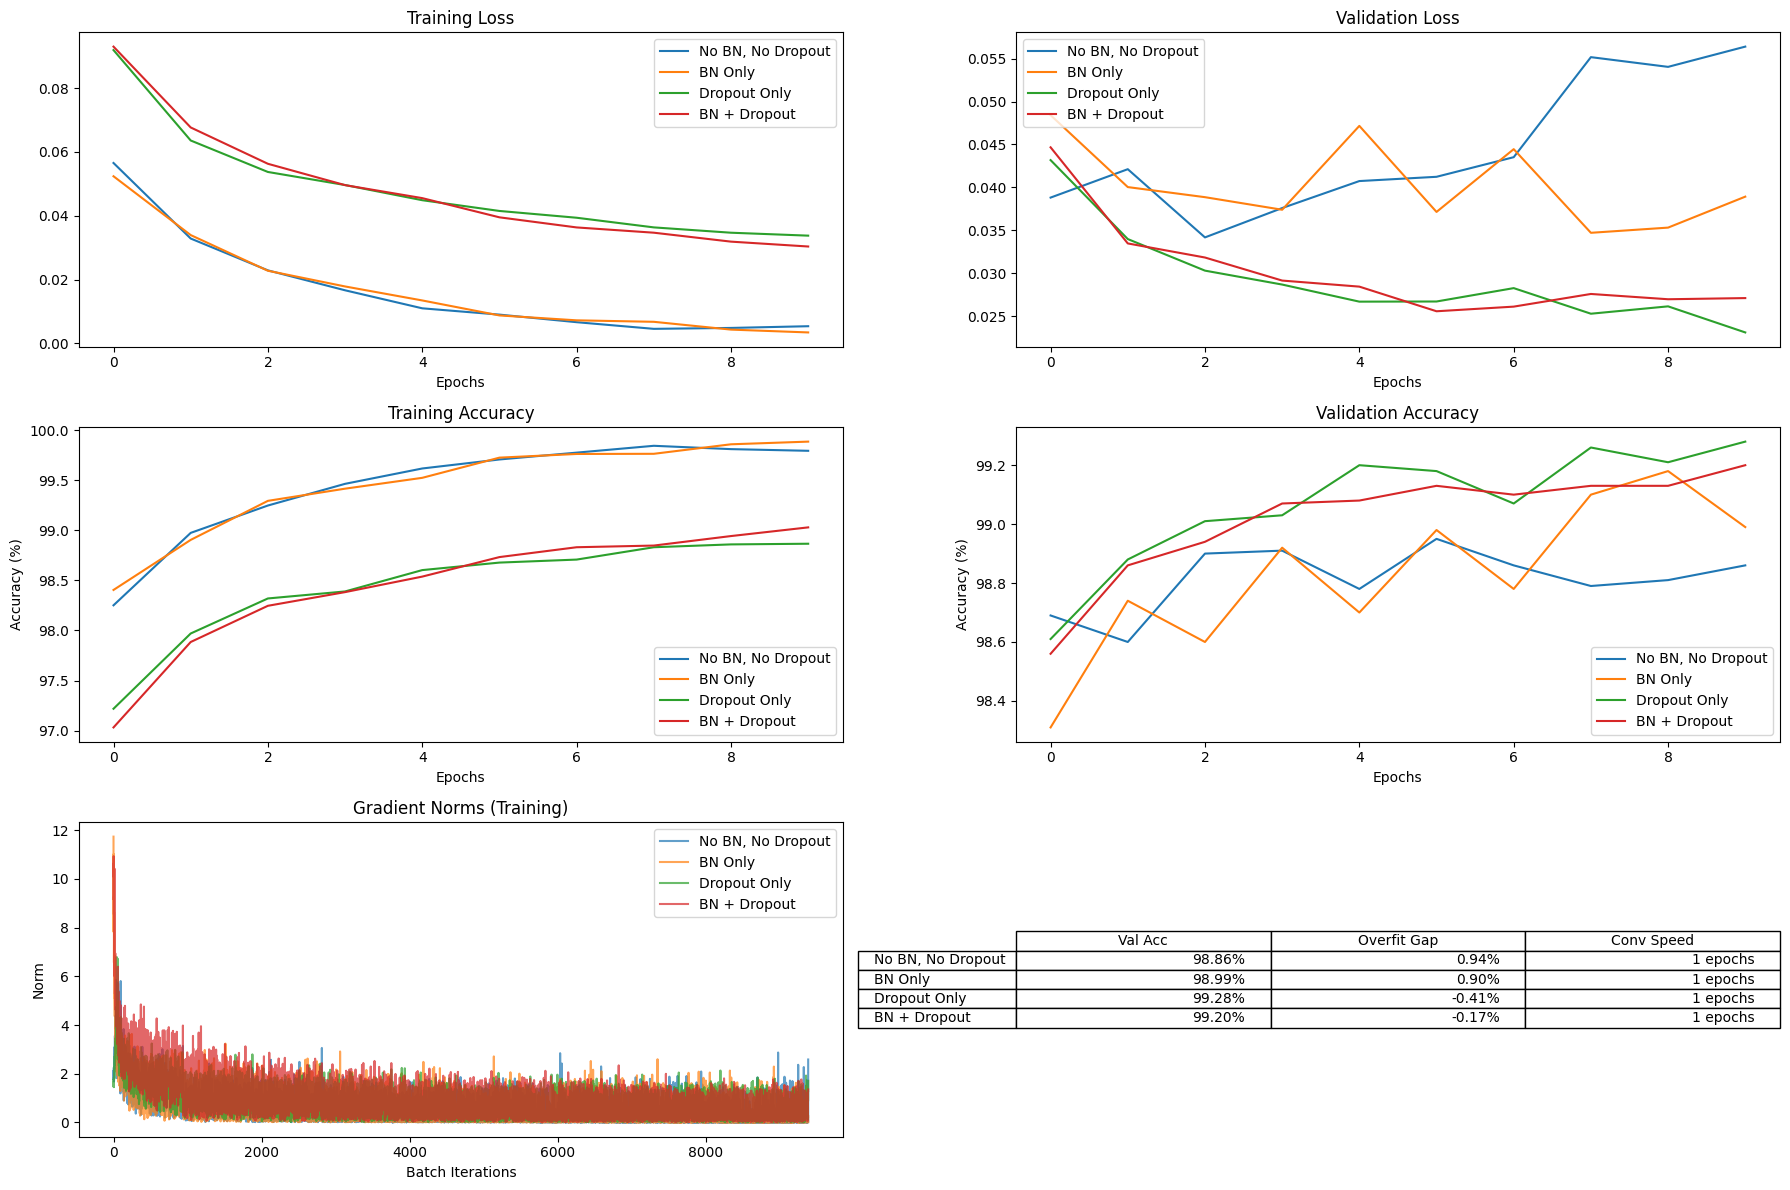

In [104]:
def bn_dropout_analysis(epochs=10): # Batch Normalization (BN): common regularization techniques in deep learning.
    # Test configurations
    configs = [
        {'name': 'No BN, No Dropout', 'use_bn': False, 'dropout': 0.0},
        {'name': 'BN Only', 'use_bn': True, 'dropout': 0.0},
        {'name': 'Dropout Only', 'use_bn': False, 'dropout': 0.5},
        {'name': 'BN + Dropout', 'use_bn': True, 'dropout': 0.5}
    ]

    results = {}

    for config in configs:
        print(f"\n=== Training: {config['name']} ===")
        model = SimpleCNN(
            num_classes=10,
            dropout=config['dropout'],
            use_bn=config['use_bn']
        )
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'grad_norms': []  # Track gradient norms for stability
        }

        for epoch in range(epochs):
            # Train
            model.train()
            epoch_grad_norms = []

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()

                # Record gradient norms
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                metrics['grad_norms'].append(total_norm ** 0.5)

                optimizer.step()

            # Evaluation
            train_loss, train_acc = train_epoch_2(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = eval_model(model, val_loader, criterion, device)

            metrics['train_loss'].append(train_loss)
            metrics['val_loss'].append(val_loss)
            metrics['train_acc'].append(train_acc)
            metrics['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Grad Norm: {metrics['grad_norms'][-1]:.2f}")

        results[config['name']] = metrics

    # Visualization
    plt.figure(figsize=(18, 12))

    # Loss curves
    plt.subplot(3, 2, 1)
    for name, data in results.items():
        plt.plot(data['train_loss'], label=name)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(3, 2, 2)
    for name, data in results.items():
        plt.plot(data['val_loss'], label=name)
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Accuracy curves
    plt.subplot(3, 2, 3)
    for name, data in results.items():
        plt.plot(data['train_acc'], label=name)
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(3, 2, 4)
    for name, data in results.items():
        plt.plot(data['val_acc'], label=name)
    plt.title('Validation Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epochs')
    plt.legend()

    # Gradient norms
    plt.subplot(3, 2, 5)
    for name, data in results.items():
        plt.plot(data['grad_norms'], label=name, alpha=0.7)
    plt.title('Gradient Norms (Training)')
    plt.xlabel('Batch Iterations')
    plt.ylabel('Norm')
    plt.legend()

    # Final metrics table
    plt.subplot(3, 2, 6)
    cell_text = []
    for name in results.keys():
        final_val_acc = results[name]['val_acc'][-1]
        train_val_gap = results[name]['train_acc'][-1] - final_val_acc
        conv_speed = np.argmax(np.array(results[name]['val_acc']) > 0.9 * max(results[name]['val_acc']))
        cell_text.append([
            f"{final_val_acc:.2f}%",
            f"{train_val_gap:.2f}%",
            f"{conv_speed+1} epochs"
        ])

    plt.table(cellText=cell_text,
          rowLabels=list(results.keys()),
          colLabels=['Val Acc', 'Overfit Gap', 'Conv Speed'],
          loc='center')

    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the analysis
bn_dropout_analysis(epochs=10)